# Analysis of exploratory behaviour aligned to onset

## Similarity between noise and signal correlation matrix evolution for single mouse and scaling/dimension exploration
''' Created on Thrus 6 May 2021'''


In this notebook we will analyze periods of ethogram exploration as classifyed with DLC. 

First we will extract the pre and post onset signal, aligned to the time when the events start. We will compute a mean population vector in the vecinity of the onset, and then analyze the full data by computing the signal correlation matrix and the noise correlation matrix in a day by day basis. 

In [1]:
#import useful libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import pickle
import configuration
import general_statistics as stats
import figures as figs
import matplotlib.cm as cm
from matplotlib import colors
from scipy import signal
from scipy import stats as sstats
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import scipy
cmap = cm.jet
import math

In [2]:
# define mouse information, and preprocessin versions from analysis.
# load data for all sessions in this mouse and compute mean activity for each neuron.

mouse = 32363       ### mouse number id
decoding_v = 1            ## decoding version, normaly equal to one
motion_correction_v = 20  ### 100 means everything was aligned, 200 means it was also equalized, 20 is for day wise
alignment_v = 3           ## alignment version, version 3 is for day wise
equalization_v = 0        ## equalization version
source_extraction_v = 1   ## source extraction version
component_evaluation_v = 1 ## component evaluation version

# here we will do analysis with no registration
# registration_v = 2        ## registration version
sf = 10                   ## sampling frequency of the original signal 
re_sf= 10                 ## value of resampling
session_now = 1
period = int(3 * sf / re_sf)
fixed = 'None'

## define task for plotting. This will cahnge for other mice!!!!
if mouse == 56165 or mouse == 32364:
    if mouse == 56165:
        sessions = [1,2,4]       ## sessions for this particular mouse
    if mouse == 32364:
        sessions = [1,2]
    if session_now == 1:
        task = 'OVERLAPPING'
        colapse_behaviour = 1
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        if mouse == 32364:
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   
        if mouse == 56165:
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]   

    else:
        if session_now == 2:
            task = 'STABLE'
            colapse_behaviour = 2
            labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
        else:
            task = 'RANDOM'
            colapse_behaviour = 0
            labels =['Unlabel','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32365:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 2:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 3:
            task = 'OVERLAPPING'
            fixed = 'LR'
            object_fixed = 4
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]           
            
if mouse == 56166:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]

    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UR'
            object_fixed = 5
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32366:
    sessions = [2,3] ## sessions for this particular mouse
    if session_now == 3:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
            
if mouse == 32363:
    sessions = [1,2] ## sessions for this particular mouse
    if session_now == 1:
        task = 'RANDOM'
        colapse_behaviour = 0
        labels =['Rest0','Rest1', 'Navigation', 'Obj1' , 'Obj2', 'Run1', 'Run2']
        colornames=['k',"r","deepskyblue","g","blue","g","blue"]
    else:
        if session_now == 2:
            task = 'OVERLAPPING'
            fixed = 'UL'
            object_fixed = 6
            colapse_behaviour = 1
            labels =['Rest0','Rest1', 'Navigation', 'Overlap_object' , 'Moving_object','RunOO' , 'RunMO' ]
            colornames=['k',"r","deepskyblue","g","blue","g","blue"]

In [3]:
file_directory = os.environ['PROJECT_DIR'] + 'neural_analysis/data/calcium_activity_day_wise/'
timeline_file_dir = os.environ['PROJECT_DIR'] + 'neural_analysis/data/timeline/'
behaviour_dir = os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/ethogram/' + f'{mouse}' + '/session_' + f'{session_now}' + '/'
objects_dir= os.environ['PROJECT_DIR'] + 'calcium_imaging_behaviour/data/object_positions/'
figure_path = os.environ['PROJECT_DIR'] +'neural_analysis/figures/'
file_path = os.environ['PROJECT_DIR'] +'neural_analysis/data/process/cosine_similarity/'

In [4]:
# define all relevant files names and load them into a list
session = session_now

activity_list = []
timeline_list = []
behaviour_list = []
total_time = 0
day = 0
for trial in [1,6,11,16]:
    
    beh_file_name_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_day_' + f'{day+1}' + '_likelihood_0.75_ethogram.npy'
    ## LOAD BEHAVIOUR
    behaviour = np.load(behaviour_dir + beh_file_name_1)
    reshape_behaviour = np.reshape(behaviour[:int(int(behaviour.shape[0]/re_sf)*re_sf)],(int(behaviour.shape[0]/re_sf),re_sf))
    resample_beh1 = np.reshape(scipy.stats.mode(reshape_behaviour,axis=1)[0],reshape_behaviour.shape[0])
    
    ## LOAD TIMELINE
    time_file_session_1 =  'mouse_'+ f'{mouse}'+'_session_'+ f'{session}' +'_trial_'+ f'{trial}'+'_v1.3.1.0_10.pkl'

    timeline_file= open(timeline_file_dir + time_file_session_1,'rb')
    timeline_info = pickle.load(timeline_file)
    timeline_1 = np.zeros(len(timeline_info) + 1)
    for i in range(len(timeline_info)):
        timeline_1[i] = timeline_info[i][1]
    timeline_1[len(timeline_info)] = behaviour.shape[0]
    timeline = timeline_1/re_sf
    time_lenght = 10
    resample_timeline = timeline_1/re_sf
    timeline_list.append(resample_timeline)
    
    behaviour_list.append(resample_beh1)
    total_time = total_time + behaviour.shape[0]
    
    
    file_name_session_1 = 'mouse_' + f'{mouse}' + '_session_' + f'{session}' + '_trial_'+ f'{trial}'+'_v' + f'{decoding_v}' + '.4.' + f'{motion_correction_v}' + \
                          '.' + f'{alignment_v}' + '.' + f'{equalization_v}' + '.' + f'{source_extraction_v}' + '.' + \
                          f'{component_evaluation_v}' +  '.0.npy'

    ##load activity and timeline
    activity = np.load(file_directory + file_name_session_1)
    neural_activity1 = activity[1:,:]
    ## z-score neural activity
    neural_activity = sstats.zscore(neural_activity1)
    ##downsample neural activity
    resample_neural_activity_mean, resample_neural_activity_std = stats.resample_matrix(neural_activity=neural_activity,
                                                                                        re_sf=re_sf)
    
    activity_list.append(resample_neural_activity_mean)
    
    day = day + 1

In [5]:
## define targets of behaviour according to protocol (random, overlapping and stable)

id_target = [0,1,2,3,4,5,6] # 0: unlabeled, 1:resting, 2:Navigation, 3: Obj1, 4:Obj2, 5:Run1, 6:Run2

if colapse_behaviour == 0 : # RANDOM
    for day in range(len(behaviour_list)):
        for trial in range(5):
            behaviour_trial = behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])]
            objects = np.unique(behaviour_trial)
            selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
            index0 = np.where(behaviour_trial==objects[selected_object])[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-4], behaviour_trial!=objects[selected_object]))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-3], behaviour_trial!=objects[selected_object]))
            behaviour_trial[index0] = 3
            behaviour_trial[index1] = 4
            behaviour_trial[index2] = 4            
            
            index0 = np.where(behaviour_trial==objects[selected_object]+4)[0]
            index1 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-2], behaviour_trial!=objects[selected_object]+4))
            index2 = np.where(np.logical_and(behaviour_trial==objects[len(objects)-1], behaviour_trial!=objects[selected_object]+4))
            behaviour_trial[index0] = 5
            behaviour_trial[index1] = 6
            behaviour_trial[index2] = 6 
            
            behaviour_list[day][int(timeline_list[day][2*trial]):int(timeline_list[day][2*trial+1])] = behaviour_trial


if colapse_behaviour == 1 : #OVERLAPPING
    for day in range(len(behaviour_list)):
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed)[0]] = 100
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=3, behaviour_list[day]<=6))[0]] = 4
        behaviour_list[day][np.where(behaviour_list[day] == 100)[0]] = 3        
        behaviour_list[day][np.where(behaviour_list[day] == object_fixed +4)[0]] = 200        
        behaviour_list[day][np.where(np.logical_and(behaviour_list[day]>=7, behaviour_list[day]<=10))[0]] = 6
        behaviour_list[day][np.where(behaviour_list[day] == 200)[0]] = 5        


if colapse_behaviour == 2: #STABLE
    for day in range(len(behaviour_list)):
        objects = np.unique(behaviour_list[day])
        selected_object = np.random.randint(len(objects)-4,len(objects)-2,1)
        index0 = np.where(behaviour_list[day]==objects[selected_object])[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-4], behaviour_list[day]!=objects[selected_object]))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-3], behaviour_list[day]!=objects[selected_object]))
        behaviour_list[day][index0] = 3
        behaviour_list[day][index1] = 4
        behaviour_list[day][index2] = 4      
    
        index0 = np.where(behaviour_list[day]==objects[selected_object]+4)[0]
        index1 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-2], behaviour_list[day]!=objects[selected_object]+4))
        index2 = np.where(np.logical_and(behaviour_list[day]==objects[len(objects)-1], behaviour_list[day]!=objects[selected_object]+4))
        behaviour_list[day][index0] = 5
        behaviour_list[day][index1] = 6
        behaviour_list[day][index2] = 6  

In [6]:
# for each day creates a list that counts and saves times of different events.

events_day_list = []
events_counter_day_list = []
events_time_starts_day = []
for day in range(len(behaviour_list)):
    events_list = []
    events_counter_list = []
    events_time_starts = []
    start_counter = 100
    counter = 0
    for i in range(behaviour_list[day].shape[0]):
        if behaviour_list[day][i] != start_counter:
            events_list.append(start_counter)
            events_counter_list.append(counter)
            events_time_starts.append(i)
            start_counter = behaviour_list[day][i]
            counter = 1
        else:
            counter = counter + 1
    events_day_list.append(events_list)
    events_counter_day_list.append(events_counter_list)
    events_time_starts_day.append(events_time_starts)

In [7]:
## take neural activity for events in days

events_activity= []
for day in range(len(behaviour_list)):
    target_activity_day = []
    events = np.array(events_day_list[day])
    events_counter = np.array(events_counter_day_list[day])
    events_time = np.array(events_time_starts_day[day])
    for target in id_target:
        target_activity = []
        position_events = np.where(events == target)[0]
        events_duration = events_counter[position_events]   # convert to seconds
        time = events_time[position_events]
        i = 0
        for event in events_duration:
            if event > 0:
                local_activity = activity_list[day][:,time[i]-period:time[i]+period]
                target_activity.append(local_activity)
            i = i + 1
        target_activity_day.append(target_activity)
    events_activity.append(target_activity_day)

In [8]:
### compute signal and noise correlation day by day

# compute the mean and z-score the traces
mean_over_events = []
for day in range(len(behaviour_list)):
    mean_over_events_day = []
    for target in id_target:
        mean_events = np.mean(events_activity[day][target],axis=0)
        mean_over_events_day.append(mean_events)
    mean_over_events.append(mean_over_events_day)

signal_corr_matrix = []
noise_corr_matrix = []

signal_corr_flatten = []
noise_corr_flatten = []


for day in range(len(behaviour_list)):
    signal_corr_matrix_day = []
    noise_corr_matrix_day = []

    signal_corr_flatten_day = []
    noise_corr_flatten_day = []
    
    for target in id_target:

        corr_matrix2 = stats.corr_matrix(neural_activity = mean_over_events[day][target])
        signal_corr_matrix_day.append(corr_matrix2)
        signal_corr_flatten_day.append(np.array(corr_matrix2.flatten().reshape(-1,1)))

        activation = events_activity[day][target]
        matrix = np.zeros((activation[0].shape[0],2*period*len(activation)))
        for i in range(len(activation)):
            matrix[:,i*2*period:(i+1)*2*period] = activation[i] - mean_over_events[day][target]
        corr_matrix = stats.corr_matrix(neural_activity = matrix)
        noise_corr_matrix_day.append(corr_matrix)
        noise_corr_flatten_day.append(np.array(corr_matrix.flatten().reshape(-1,1)))
    signal_corr_matrix.append(signal_corr_matrix_day)
    noise_corr_matrix.append(noise_corr_matrix_day)
    signal_corr_flatten.append(signal_corr_flatten_day)
    noise_corr_flatten.append(noise_corr_flatten_day)


/home/melisa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


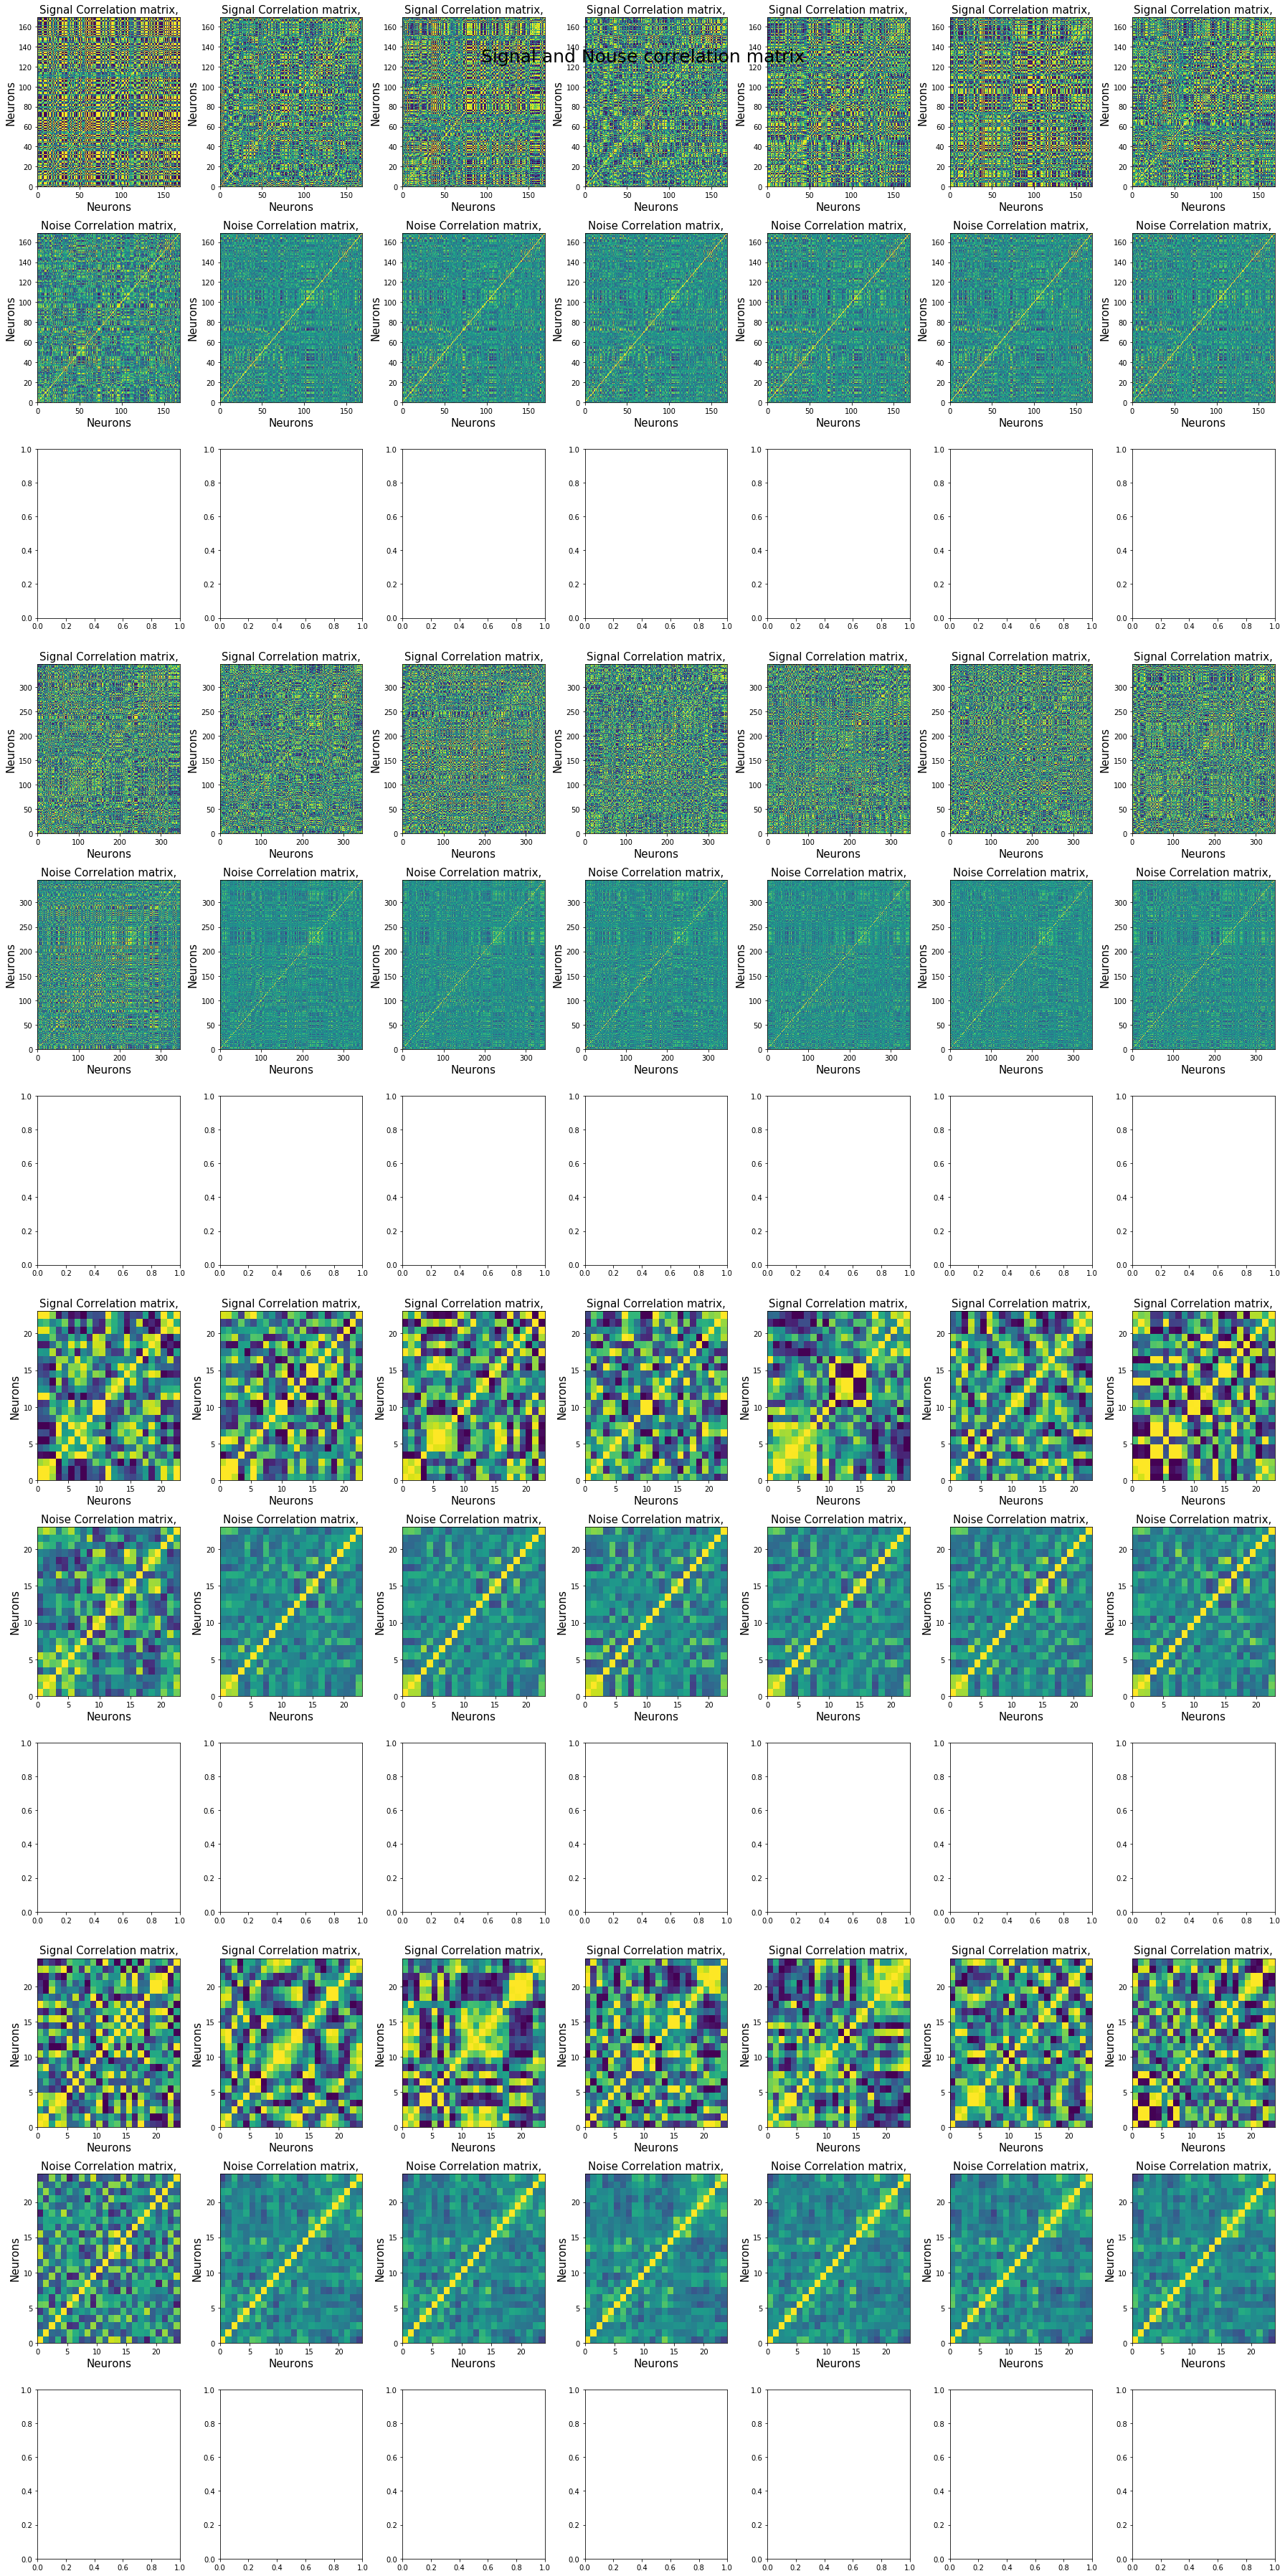

In [9]:
fig, axes = plt.subplots(12,7)

for day in range(len(behaviour_list)):
    
    for target in id_target:

        vmin_corr = -1
        vmax_corr = 1
        axes[day*3,target].set_ylabel('Neurons', fontsize = 15)
        axes[day*3,target].set_xlabel('Neurons', fontsize = 15)
        axes[day*3,target].set_title('Signal Correlation matrix,', fontsize = 15)
        mesh1 = axes[day*3,target].pcolormesh(signal_corr_matrix[day][target], cmap = 'viridis')
        mesh1.set_clim(vmin_corr,vmax_corr)
        #fig.colorbar(mesh3,ax=axes[1,target])

        axes[day*3+1,target].set_ylabel('Neurons', fontsize = 15)
        axes[day*3+1,target].set_xlabel('Neurons', fontsize = 15)
        axes[day*3+1,target].set_title('Noise Correlation matrix,', fontsize = 15)
        mesh2 = axes[day*3+1,target].pcolormesh(noise_corr_matrix[day][target], cmap = 'viridis')
        mesh2.set_clim(vmin_corr,vmax_corr)
        #fig.colorbar(mesh6,ax=axes[2,target])

    fig.tight_layout()
    fig.set_size_inches(25,50)
    fig.suptitle('Signal and Nouse correlation matrix', fontsize = 25)

    figure_name = figure_path +'calcium_activity_corr_matrix_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                                 '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
    fig.savefig(figure_name)

In [10]:
### compute distance as cosine similarity between signal and noise corr matrix
signal_list = []
noise_list = []
for day in range(len(behaviour_list)):
    signal_cosine_similarity = np.zeros((len(id_target),len(id_target)))
    noise_cosine_similarity = np.zeros((len(id_target),len(id_target)))
    for target1 in id_target:
        for target2 in id_target:
            signal_cosine_similarity[target1,target2] = cosine_similarity(signal_corr_flatten[day][target1].T,signal_corr_flatten[day][target2].T)
            noise_cosine_similarity[target1,target2] = cosine_similarity(noise_corr_flatten[day][target1].T,noise_corr_flatten[day][target2].T)
    signal_list.append(signal_cosine_similarity)
    noise_list.append(noise_cosine_similarity)

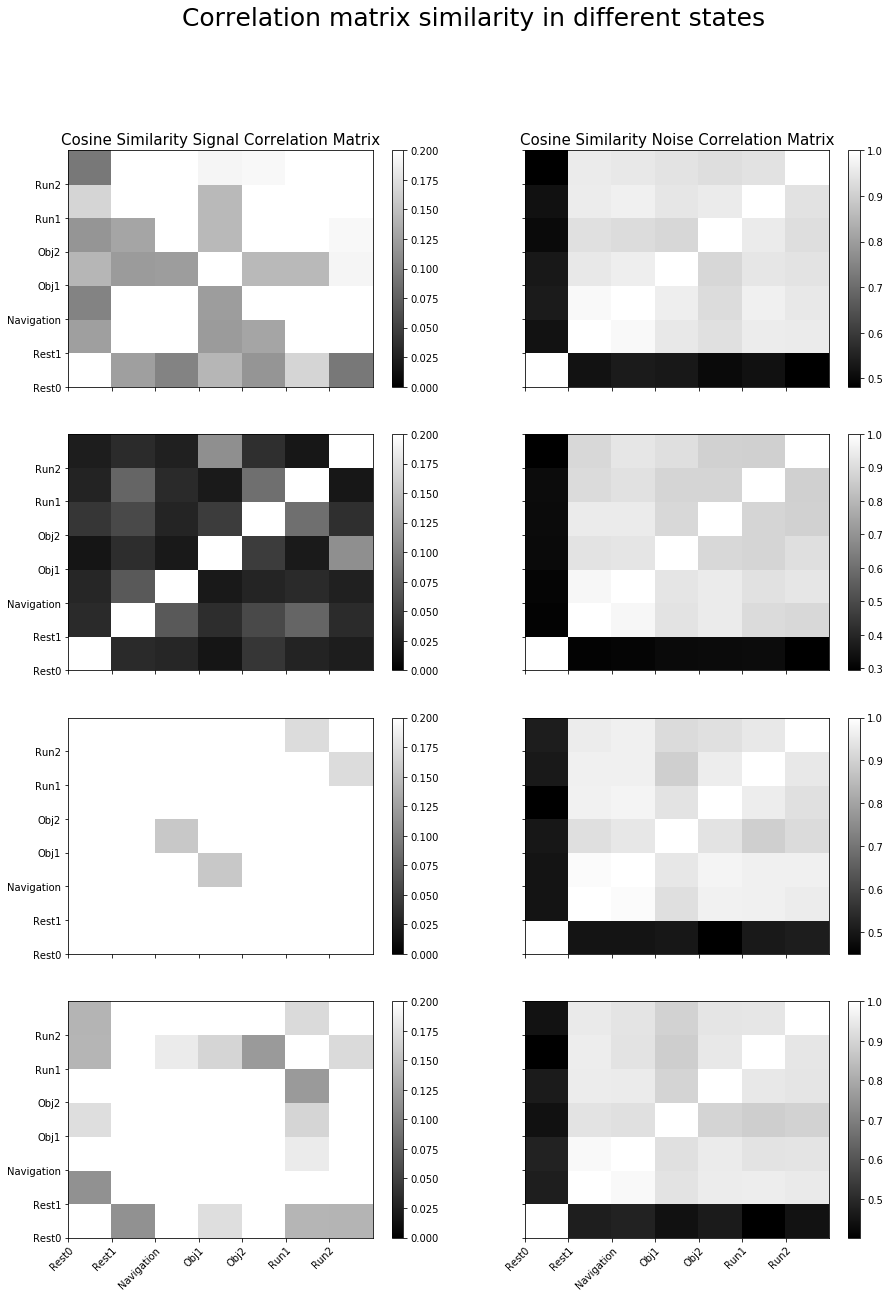

In [11]:
fig, axes = plt.subplots(4,2)

for day in range(len(behaviour_list)):
    mesh0 = axes[day,0].pcolormesh(signal_list[day], cmap = 'gray')
    vmin= 0
    vmax=0.2
    mesh0.set_clim(vmin,vmax)
    fig.colorbar(mesh0,ax=axes[day,0])
    if day == 0:
        axes[day,0].set_title('Cosine Similarity Signal Correlation Matrix', fontsize = 15)

    mesh1 = axes[day,1].pcolormesh(noise_list[day], cmap = 'gray')
    #vmin= 0
    #vmax=1
    #mesh1.set_clim(vmin,vmax)
    fig.colorbar(mesh1,ax=axes[day,1])
    if day == 0:
        axes[day,1].set_title('Cosine Similarity Noise Correlation Matrix', fontsize = 15)


    for i in [0,1]:
        axes[day,i].set_yticklabels([])
        if i ==0:
            x_pos = np.arange(0,len(labels))
            axes[day,i].set_yticks(x_pos)
            axes[day,i].set_yticklabels(labels)
        axes[day,i].set_xticks(x_pos)
        axes[day,i].set_xticklabels([])        
        if day == (len(behaviour_list)-1):
            axes[day,i].set_xticks(x_pos)
            axes[day,i].set_xticklabels(labels)
            plt.setp(axes[day,i].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
    
fig.set_size_inches(15,20)
fig.suptitle('Correlation matrix similarity in different states', fontsize = 25)

figure_name = figure_path +'Correlation_matrix_signal_and_noise_cosine_similarity_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'
fig.savefig(figure_name)

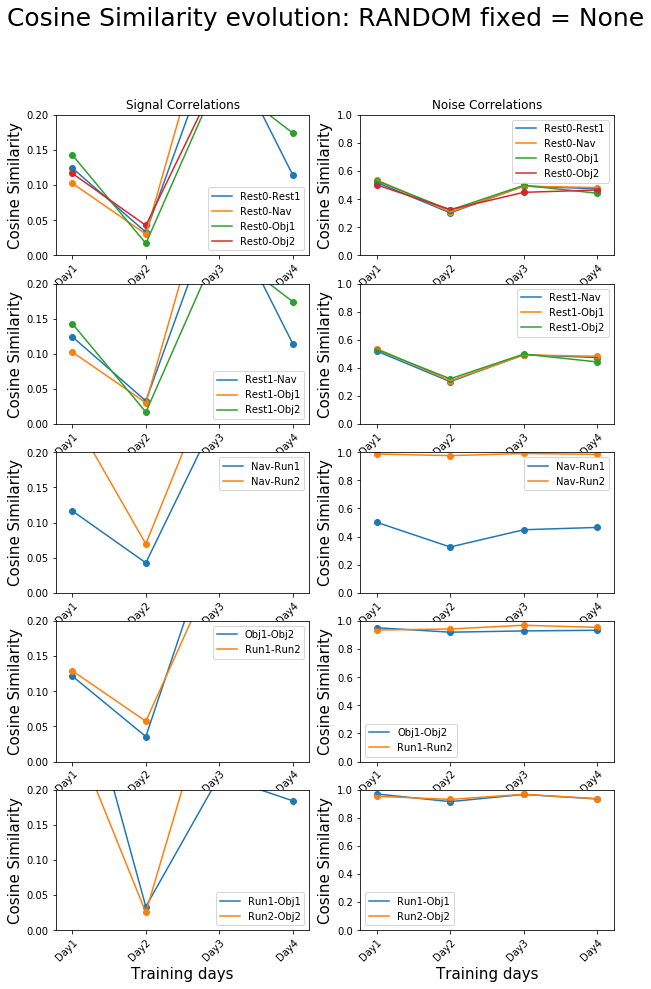

In [12]:

evolution1 = np.zeros((4,13))
evolution2 = np.zeros((4,13))

for day in range(len(signal_list)):
    
    evolution1[day][0] = signal_list[day][0,1]
    evolution1[day][1] = signal_list[day][0,2]
    evolution1[day][2] = signal_list[day][0,3]
    evolution1[day][3] = signal_list[day][0,4]    
    
    evolution1[day][4] = signal_list[day][1,2]
    evolution1[day][5] = signal_list[day][1,3]
    evolution1[day][6] = signal_list[day][1,4]
    
    evolution1[day][7] = signal_list[day][2,5]
    evolution1[day][8] = signal_list[day][2,6] 
    
    evolution1[day][9] = signal_list[day][3,4]
    evolution1[day][10] = signal_list[day][5,6]
    
    evolution1[day][11] = signal_list[day][3,5]
    evolution1[day][12] = signal_list[day][4,6]
    
    evolution2[day][0] = noise_list[day][0,1]
    evolution2[day][1] = noise_list[day][0,2]
    evolution2[day][2] = noise_list[day][0,3]
    evolution2[day][3] = noise_list[day][0,4]    
    
    evolution2[day][4] = noise_list[day][1,2]
    evolution2[day][5] = noise_list[day][1,3]
    evolution2[day][6] = noise_list[day][1,4]
    
    evolution2[day][7] = noise_list[day][2,5]
    evolution2[day][8] = noise_list[day][2,6] 
    
    evolution2[day][9] = noise_list[day][3,4]
    evolution2[day][10] = noise_list[day][5,6]
    
    evolution2[day][11] = noise_list[day][3,5]
    evolution2[day][12] = noise_list[day][4,6]

condition0 = ['Rest0-Rest1','Rest0-Nav','Rest0-Obj1','Rest0-Obj2'] 
condition1 = ['Rest1-Nav','Rest1-Obj1','Rest1-Obj2'] 
condition2 = ['Nav-Run1', 'Nav-Run2']
condition3 = ['Obj1-Obj2','Run1-Run2']
condition4 = ['Run1-Obj1','Run2-Obj2']
              
x_axes = ['Day1', 'Day2', 'Day3', 'Day4']
fig, axes = plt.subplots(5,2)

for i in range(4):
    axes[0,0].scatter([1,2,3,4],evolution1[:,i])
    axes[0,0].plot([1,2,3,4],evolution1[:,i])  
    
    axes[0,1].scatter([1,2,3,4],evolution2[:,i])
    axes[0,1].plot([1,2,3,4],evolution2[:,i])
    
axes[0,0].legend(condition0)
axes[0,1].legend(condition0)
axes[0,0].set_title('Signal Correlations')
axes[0,1].set_title('Noise Correlations')

for i in range(3):
    axes[1,0].scatter([1,2,3,4],evolution1[:,i])
    axes[1,0].plot([1,2,3,4],evolution1[:,i])   
    
    axes[1,1].scatter([1,2,3,4],evolution2[:,i])
    axes[1,1].plot([1,2,3,4],evolution2[:,i])   
axes[1,0].legend(condition1)
axes[1,1].legend(condition1)

for i in range(3,5):
    axes[2,0].scatter([1,2,3,4],evolution1[:,i])
    axes[2,0].plot([1,2,3,4],evolution1[:,i]) 
    
    axes[2,1].scatter([1,2,3,4],evolution2[:,i])
    axes[2,1].plot([1,2,3,4],evolution2[:,i]) 
axes[2,0].legend(condition2)
axes[2,1].legend(condition2)

for i in range(5,7):
    axes[3,0].scatter([1,2,3,4],evolution1[:,i])
    axes[3,0].plot([1,2,3,4],evolution1[:,i])
    
    axes[3,1].scatter([1,2,3,4],evolution2[:,i])
    axes[3,1].plot([1,2,3,4],evolution2[:,i]) 

axes[3,1].legend(condition3)  
axes[3,0].legend(condition3)

for i in range(7,9):
    axes[4,0].scatter([1,2,3,4],evolution1[:,i])
    axes[4,0].plot([1,2,3,4],evolution1[:,i]) 
    
    axes[4,1].scatter([1,2,3,4],evolution2[:,i])
    axes[4,1].plot([1,2,3,4],evolution2[:,i]) 
    
axes[4,0].legend(condition4)
axes[4,1].legend(condition4)

for i in range(5):
    for j in range(2):
        axes[i,j].set_xlabel('Training days', fontsize = 15)
        axes[i,j].set_ylabel('Cosine Similarity', fontsize = 15)
        x_pos = np.arange(1,5)
        if j==0:
            axes[i,j].set_ylim([0, 0.2])
        if j==1:
            axes[i,j].set_ylim([0, 1])
        axes[i,j].set_xticks(x_pos)
        axes[i,j].set_xticklabels(x_axes)
        plt.setp(axes[i,j].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
              
#fig.tight_layout()
fig.set_size_inches(10,15)
fig.suptitle('Cosine Similarity evolution: ' + task + ' fixed = ' + fixed  , fontsize = 25)
#fig.suptitle('Distance evolution_inspection: ' + task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'cos_sim_evolution_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

#figure_name = figure_path +'distance_evolution_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_inspection.png'


fig.savefig(figure_name)

file_name1 = file_path + 'signal_cos_sim_evol_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.npy'
file_name2 = file_path + 'noise_cos_sim_evol_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.npy'
np.save(file_name1,evolution1)
np.save(file_name2,evolution2)

### ISOMAP IN SIGNAL AND NOISE CORRELATION MATRIX

In [13]:
from sklearn.manifold import Isomap as iso

In [14]:
embedding = iso(n_components=2)
iso_signal = []
iso_noise = []

for day in range(len(signal_list)):
    X_transformed = embedding.fit_transform(signal_list[day])
    iso_signal.append(X_transformed)
    
    Y_transformed = embedding.fit_transform(noise_list[day])
    iso_noise.append(Y_transformed)

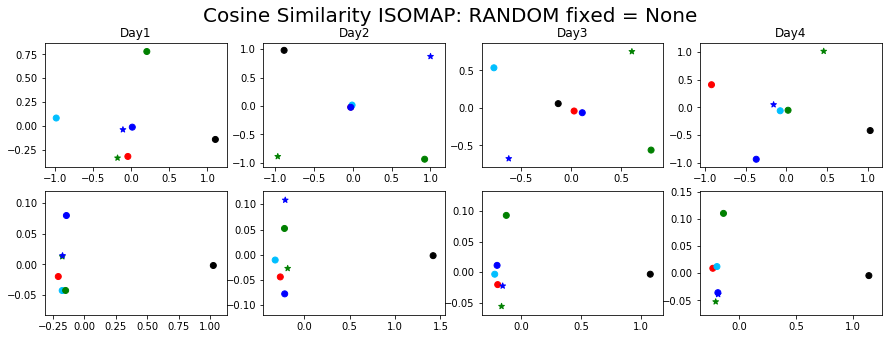

In [15]:
fig, axes = plt.subplots(2,4)

for day in range(len(signal_list)):
    
    axes[0,day].scatter(iso_signal[day][0:5,0],iso_signal[day][0:5,1],color = colornames[0:5])
    axes[1,day].scatter(iso_noise[day][0:5,0],iso_noise[day][0:5,1], color = colornames[0:5])

    axes[0,day].scatter(iso_signal[day][5:7,0],iso_signal[day][5:7,1],color = colornames[5:7], marker = "*")
    axes[1,day].scatter(iso_noise[day][5:7,0],iso_noise[day][5:7,1],color = colornames[5:7], marker = "*")

    axes[0,day].set_title('Day' + f'{day+1}')

fig.set_size_inches(15,5)
fig.suptitle('Cosine Similarity ISOMAP: ' + task + ' fixed = ' + fixed  , fontsize = 20)
#fig.suptitle('Distance evolution_inspection: ' + task + ' fixed = ' + fixed  , fontsize = 25)

figure_name = figure_path +'cos_sim_ISOMAP_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'.png'

#figure_name = figure_path +'distance_evolution_events_mouse_'+f'{mouse}'+'_session_'+f'{session}'+\
#                             '_binsize_'+f'{re_sf}'+'_period_'+ f'{period}'  +'_inspection.png'


fig.savefig(figure_name)

### CLUSTERING IN CORR MATRIX

In [16]:
from sklearn.cluster import KMeans as kmeans
n_clusters = 5

In [17]:
cluster = []
for day in range(len(signal_corr_matrix)):
    cluster_day = []
    for target in id_target:
        km = kmeans(n_clusters=n_clusters, random_state=0).fit(signal_corr_matrix[day][target])
        cluster_day.append(km)
    cluster.append(cluster_day)

In [18]:
neurons = []
for day in range(len(signal_corr_matrix)):
    neurons_day = []
    for target in id_target:
        cluster_labels = cluster[day][target].labels_
        neurons_cluster = []
        for i in range(n_clusters):
            neurons_id = np.where(cluster_labels == i)[0]
            neurons_cluster.append(neurons_id)
        neurons_day.append(neurons_cluster)
    neurons.append(neurons_day)

In [19]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return float(len(s1.intersection(s2)) / len(s1.union(s2)))

In [20]:
jaccard_sim = []
for day in range(len(signal_corr_matrix)):
    jaccard_sim_day= []
    for target1 in range(0,7):
        for target2 in range(target1+1,7):
            distance = np.zeros((n_clusters,n_clusters))
            for i in range(n_clusters):
                list1 = list(neurons[day][target1][i])
                for j in range(n_clusters):
                    list2 = list(neurons[day][target2][j])
                    distance[i,j] = jaccard_similarity(list1,list2)
            jaccard_sim_day.append(distance)
    jaccard_sim.append(jaccard_sim_day)

In [21]:
mean_jaccard_day = np.zeros((4,len(jaccard_sim[0])))
for day in range(len(signal_corr_matrix)):
    jaccard_com = np.zeros((len(jaccard_sim[day]),1))
    for comparison in range(len(jaccard_sim[day])):
        max_overlap = np.mean(np.max(jaccard_sim[day][comparison],axis=1))
        jaccard_com[comparison] = max_overlap
        mean_jaccard_day[day,comparison]=max_overlap

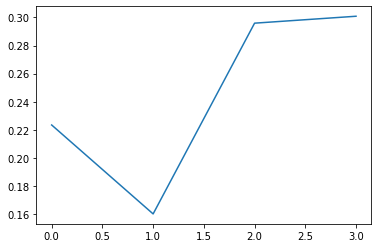

In [22]:
plt.plot(np.mean(mean_jaccard_day,axis=1))